In [3]:
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [4]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

## Sleep Study

In [5]:
import pandas as pd
sleepstudy = pd.read_csv("data/sleepstudy.csv")

In [6]:
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


In [7]:
# adding a column that numbers the subjects from 0 to n
raw_ids = np.unique(sleepstudy['Subject'])
raw2newid = {x:np.where(raw_ids == x)[0][0] for x in raw_ids}

sleepstudy['SeqSubject'] = sleepstudy['Subject'].map(raw2newid)
sleepstudy

,Reaction,Days,Subject,SeqSubject
0,249.5600,0,308,0
1,258.7047,1,308,0
2,250.8006,2,308,0
3,321.4398,3,308,0
4,356.8519,4,308,0
...,...,...,...,...
175,329.6076,5,372,17
176,334.4818,6,372,17
177,343.2199,7,372,17
178,369.1417,8,372,17


In [8]:
with pm.Model() as sleep_model:
    
    # In this model, we're going to say the alphas (individuals' intercepts; their starting reaction time)
    # and betas (individuals' slopes; how much worse they get with lack of sleep) are normally distributed.
    # We'll specify that we're certain about the mean of those distribution [more on that later], but admit
    # we're uncertain about how much spread there is (i.e. uncertain about the SD). Tau_alpha and Tau_beta 
    # will be the respective SD.
    #
    # Of course, the SDs must be positive (negative SD isn't mathematically possible), so we draw them from
    # a Gamma, which cannot ever output negative numbers. Here, we use alpha and beta values that spread the
    # distribution: "the SD could be anything!". If we had more intuition (e.g. "the starting reaction times can't
    # have SD above 3,000") we would plot Gamma(a,b) and tune the parameters so that there was little mass
    # above 3,000, then use those values below)
    tau_alpha = pm.Gamma('tau_alpha', alpha=.001, beta=.001)
    tau_beta = pm.Gamma('tau_beta', alpha=.001, beta=.001)
    
    # Across the population of people, we suppose that
    # the slopes are normally distributed, as are the intercepts,
    # and the two are drawn independently
    #
    # (Here, we hard-code assumed means, but we don't have to.
    # In general, these should be set from our pre-data intuition,
    # rather than from plots/exploration of the data)
    alpha = pm.Normal('alpha', mu=300, tau=tau_alpha, shape=len(raw_ids))
    beta = pm.Normal('beta', mu=10, tau=tau_beta, shape=len(raw_ids))
    
    # Remember: there's only one alpha/beta per person, but
    # we have lots of observations per person. The below
    # builds a vector with one entry per observation, recording
    # the alpha/beta we want to use with that observation.
    #
    # That is, the length is 180, but it only has 17 unique values,
    # matching the 17 unique patients' personal slopes or intercepts
    intercepts = alpha[sleepstudy['SeqSubject']]
    slopes = beta[sleepstudy['SeqSubject']]
    
    # now we have the true/predicted response time for each observation (each row of original data)
    # (Here we use pm.Deterministic to signal that this is something we'll care about)
    mu_i = pm.Deterministic('mu_i', intercepts + slopes*sleepstudy['Days'])
    
    # The _observed_ values are noisy versions of the hidden true values, however! 
    # Specifically, we model them as a normal at the true value and single unknown variance
    # (one explanation: we're saying the measurement equipment adds normally-distributed noise tau_obs
    # so noise doesn't vary from observation to observation or person to person: there's just one universal
    # noise level)
    tau_obs = pm.Gamma('tau_obs', 0.001, 0.001)
    obs = pm.Normal('observed', mu=mu_i, tau=tau_obs, observed=sleepstudy['Reaction'])
    
    trace = pm.sample(2000, tune=2000, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_alpha, tau_beta, alpha, beta, tau_obs]


Output()

ValueError: Not enough samples to build a trace.

In [25]:
# this command can take a few minutes to finish... or never :-/
#az.plot_trace(trace);

In [26]:
trace_summary(trace, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

,mean,sd,2.5%,25.0%,50.0%,75.0%,97.5%
tau_alpha,0.000350,0.000128,0.000151,0.000258,0.000331,0.000423,0.000646
tau_beta,0.033206,0.014838,0.013018,0.022836,0.030393,0.040335,0.070022
alpha[0],257.834040,14.454987,229.944148,247.962640,257.772260,267.618725,286.445107
alpha[1],204.292518,13.989399,177.087320,194.931516,204.456941,213.746291,231.670159
alpha[2],206.461057,13.617250,179.737088,197.068642,206.580136,215.710585,233.184826
alpha[3],284.159428,13.595755,257.476054,275.080136,284.228639,293.167125,310.981056
alpha[4],282.423958,13.618934,255.458849,273.329468,282.454949,291.749909,309.276085
alpha[5],266.265550,13.725692,238.716189,257.158923,266.257764,275.357246,293.270628
alpha[6],275.937130,13.454455,249.434455,266.813708,275.972296,285.107552,302.221658
alpha[7],245.839110,13.473915,219.280474,236.589305,245.847390,254.824488,272.109865


In [27]:
az.summary(trace, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau_alpha,0.000,0.000,0.000,0.001,0.000,0.000,11963.0,6139.0,1.0
tau_beta,0.033,0.015,0.010,0.060,0.000,0.000,6868.0,6204.0,1.0
alpha[0],257.834,14.456,229.781,284.102,0.159,0.113,8229.0,6399.0,1.0
alpha[1],204.293,13.990,177.343,229.988,0.158,0.112,7919.0,6492.0,1.0
alpha[2],206.461,13.618,179.923,230.706,0.149,0.106,8332.0,6524.0,1.0
alpha[3],284.159,13.597,258.027,309.275,0.147,0.104,8584.0,6274.0,1.0
alpha[4],282.424,13.620,257.223,308.210,0.140,0.099,9495.0,6363.0,1.0
alpha[5],266.266,13.727,239.442,291.510,0.151,0.107,8293.0,5674.0,1.0
alpha[6],275.937,13.455,250.663,301.266,0.136,0.096,9726.0,6538.0,1.0
alpha[7],245.839,13.475,220.413,270.880,0.137,0.097,9747.0,6065.0,1.0


/home/chris/miniconda3/envs/cs109b/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


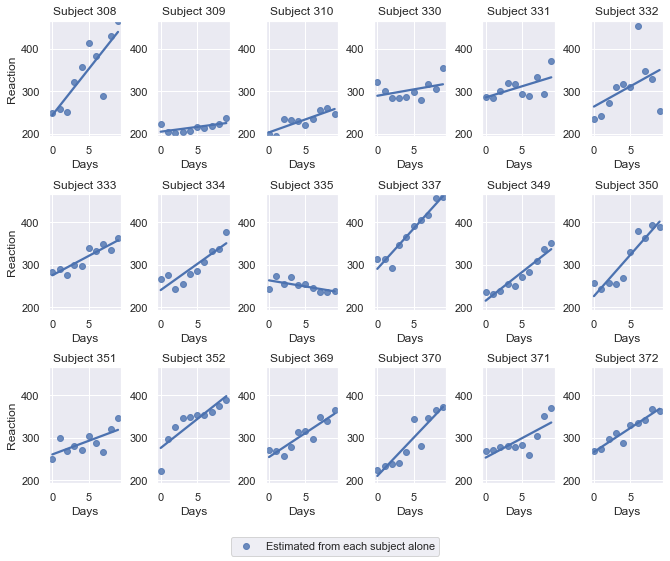

In [28]:
import statsmodels.formula.api as sm
import seaborn as sns
from matplotlib import gridspec


ymin,ymax = np.min(sleepstudy["Reaction"]),np.max(sleepstudy["Reaction"])
plt.figure(figsize=(11,8.5))
gs  = gridspec.GridSpec(3, 6)
gs.update(wspace=0.5, hspace=0.5)
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    ss_extract_ols = sm.ols(formula="Reaction~Days",data=ss_extract).fit()
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj))
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone'],loc = 'lower center', ncol=6)
_ = plt.show()

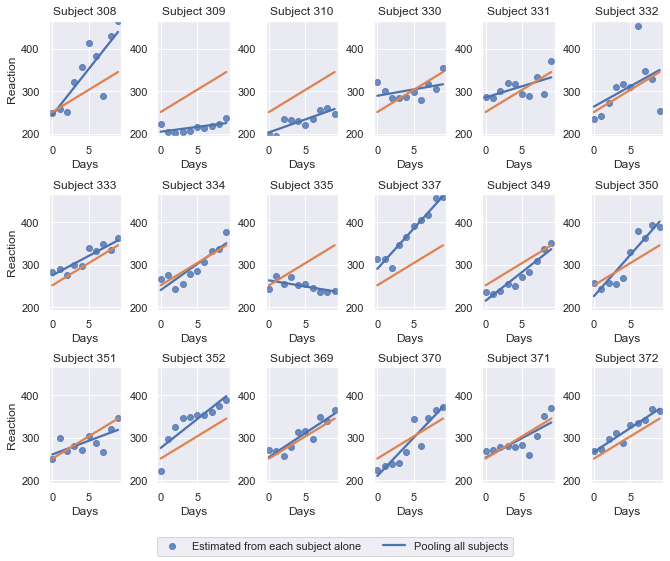

In [29]:
plt.figure(figsize=(11,8.5))
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj)) 
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects'],loc = 'lower center', ncol=6)
_ = plt.show()

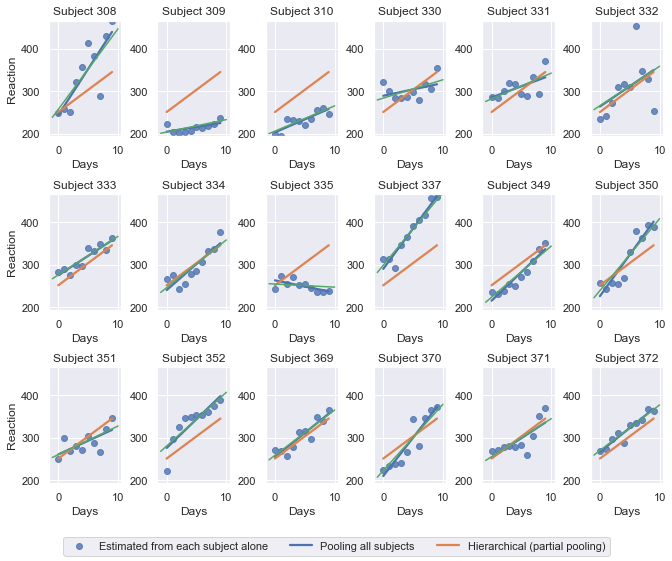

In [30]:
plt.figure(figsize=(11,8.5))
subj_arr = np.unique(sleepstudy['Subject'])
for i, subj in enumerate(subj_arr):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj)) 
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    
    subj_num = int(np.where(subj_arr==subj)[0])
    
    subjects_avg_intercept = np.mean(trace['alpha'][:,i])
    subjects_avg_slope = np.mean(trace['beta'][:,i])
    hmodel_fit = [subjects_avg_intercept + subjects_avg_slope*x for x in range(-1,11)]
    sns.lineplot(x=range(-1,11),y=hmodel_fit)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects','Hierarchical (partial pooling)'],loc = 'lower center', ncol=6)
_ = plt.show()

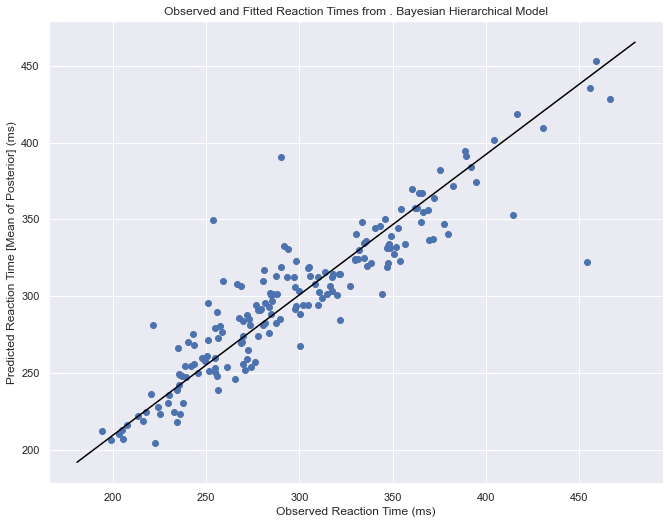

In [31]:
model_predictions = trace['mu_i'].mean(axis=0)
obs_reactions = sleepstudy['Reaction']

plt.figure(figsize=(11,8.5))
plt.scatter(sleepstudy['Reaction'], model_predictions)
plt.plot(plt.xlim(), plt.ylim(), c='black')
plt.xlabel("Observed Reaction Time (ms)")
plt.ylabel("Predicted Reaction Time [Mean of Posterior] (ms)")
plt.title("Observed and Fitted Reaction Times from . Bayesian Hierarchical Model")
plt.show()